In [1]:
import argparse
import matplotlib.pyplot as plt
from logger.plotting import plot_episode_stats
from maac.logger.run_utils import setup_logger_kwargs

In [2]:
parser = argparse.ArgumentParser(description="Experimenting Actor-Attention-Critic")
parser.add_argument("--env_id", default="5", help="Name of environment")
parser.add_argument("--buffer_length", default=int(1e6), type=int)
parser.add_argument("--n_episodes", default=5, type=int)
parser.add_argument("--climate_zone", default=5, type=int)
parser.add_argument("--episode_length", default=200, type=int)
parser.add_argument("--batch_size",
                    default=64, type=int,
                    help="Batch size for training")
parser.add_argument("--update_after", default=80)
parser.add_argument("--update_every", default=2, type=int)
parser.add_argument("--num_updates", default=1, type=int,
                    help="Number of updates per update cycle")
parser.add_argument("--exploration", default=100, type=int)
parser.add_argument("--exp_name", type=str, default="maac")
parser.add_argument("--seed", type=int, default=42)

config, unknown = parser.parse_known_args()

logger_kwargs = setup_logger_kwargs(config.exp_name, config.seed)

In [3]:
from main import run
envs, stats = run(config, logger_kwargs=logger_kwargs)

Logging data to /Users/xiejiahan/PycharmProjects/CityLearn/data/maac/maac_s42/progress.txt
Saving config:

{
    "config":	{
        "Namespace(batch_size=64, buffer_length=1000000, climate_zone=5, env_id='5', episode_length=200, exp_name='maac', exploration=100, n_episodes=5, num_updates=1, seed=42, update_after=80, update_every=2)":	{
            "batch_size":	64,
            "buffer_length":	1000000,
            "climate_zone":	5,
            "env_id":	"5",
            "episode_length":	200,
            "exp_name":	"maac",
            "exploration":	100,
            "n_episodes":	5,
            "num_updates":	1,
            "seed":	42,
            "update_after":	80,
            "update_every":	2
        }
    },
    "exp_name":	"maac",
    "logger":	{
        "<logger.logx.EpochLogger object at 0x177eeb610>":	{
            "epoch_dict":	{},
            "exp_name":	"maac",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "o

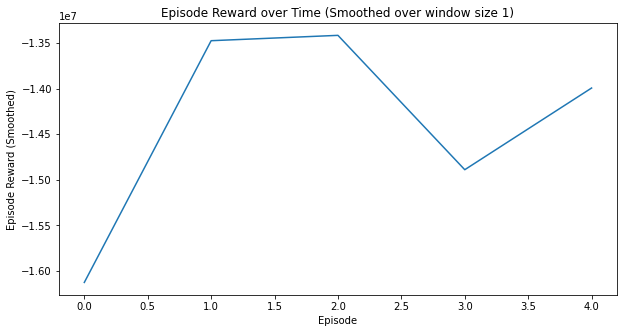

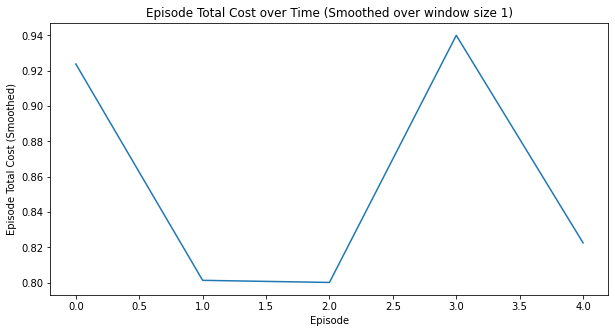

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [4]:
plot_episode_stats(stats)

In [5]:
stats.episode_costs[0]

1.2244538915250247

In [6]:
stats.episode_costs[2]

1.0391172140188696

In [8]:
stats.episode_rewards[2]

-14394874.240234375

In [9]:
costs = []
for i in range(config.n_episodes):
    costs.append(envs[i].cost())

In [10]:
costs[0]

{'ramping': 1.3090836,
 '1-load_factor': 1.454173357542482,
 'average_daily_peak': 1.1631882,
 'peak_demand': 1.3839219,
 'net_electricity_consumption': 1.0178367,
 'carbon_emissions': 1.0185196,
 'total': 1.2244538915250247,
 'coordination_score': 1.32759175480806}

In [11]:
costs[1]

{'ramping': 0.9742826,
 '1-load_factor': 1.2839945613624837,
 'average_daily_peak': 1.1408511,
 'peak_demand': 1.2071524,
 'net_electricity_consumption': 1.0074786,
 'carbon_emissions': 1.0138487,
 'total': 1.1046013245861097,
 'coordination_score': 1.1515701725900716}

In [12]:
costs[4]

{'ramping': 0.9461662,
 '1-load_factor': 1.170997895410518,
 'average_daily_peak': 1.115361,
 'peak_demand': 1.0916711,
 'net_electricity_consumption': 0.98294556,
 'carbon_emissions': 0.9900826,
 'total': 1.0495373966976769,
 'coordination_score': 1.0810490493006657}

In [13]:
from citylearn import  CityLearn
from pathlib import Path
import numpy as np
from agents.rbc import RBC

In [103]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4 - 1)
params = {'data_path':Path("/Users/xiejiahan/PycharmProjects/CityLearn/data/Climate_Zone_"+str(climate_zone)),
        'building_attributes':'building_attributes.json',
        'weather_file':'weather_data.csv',
        'solar_profile':'solar_generation_1kW.csv',
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'/Users/xiejiahan/PycharmProjects/CityLearn/buildings_state_action_space.json',
        'simulation_period': sim_period,
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'],
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [104]:
import json
import time
# Instantiating the control agent(s)
agents = RBC(actions_spaces)

# Finding which state
with open('/Users/xiejiahan/PycharmProjects/CityLearn/buildings_state_action_space.json') as file:
    actions_ = json.load(file)

indx_hour = -1
for obs_name, selected in list(actions_.values())[0]['states'].items():
    indx_hour += 1
    if obs_name=='hour':
        break
    assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"

state = env.reset()
done = False
rewards_list = []
start = time.time()
while not done:
    hour_state = np.array([[state[0][indx_hour]]])
    action = agents.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    rewards_list.append(rewards)
cost_rbc = env.cost()
end = time.time()
print(end-start)

50.092589139938354


In [105]:
rbc_env = env

In [37]:
rbc_net_elec_consumption = rbc_env.net_electric_consumption

In [25]:
first_ep_elec_consumption_to_rbc = envs[0].net_electric_consumption / rbc_net_elec_consumption

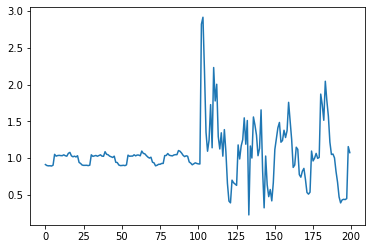

In [26]:
plt.plot(first_ep_elec_consumption_to_rbc)

In [33]:
second_ep_elec_consumption_to_rbc = envs[1].net_electric_consumption.sum() / rbc_net_elec_consumption.sum()

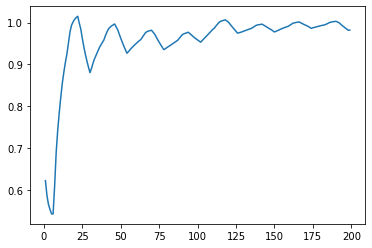

In [47]:
relative = [envs[4].net_electric_consumption[0:t].sum() / rbc_net_elec_consumption[0:t].sum() for t in range(200)]
plt.plot(relative )

In [35]:
print(np.mean(second_ep_elec_consumption_to_rbc))

1.0074786


In [40]:
rbc_net_elec_consumption[0:10]

array([160.8062, 138.6187, 133.4465, 135.0164, 130.4572, 145.8054,
        79.9596, 153.5376, 120.1112, 112.8155], dtype=float32)

In [50]:
rbc_env.carbon_emissions

array([ 84.63072 ,  75.372635,  71.73477 ,  72.174194,  70.12341 ,
        78.19994 ,  43.359886,  83.95041 ,  65.88811 ,  63.57539 ,
        71.42625 ,  75.11574 ,  50.44134 ,  53.653343,  56.46815 ,
        44.381237,  51.034885,  62.07058 ,  74.5305  ,  59.568   ,
        60.1656  ,  71.82372 ,  81.652756,  61.295834,  80.651794,
        73.606476,  76.089485,  78.65228 ,  78.27047 ,  84.17463 ,
        51.777184, 101.71324 ,  84.07298 ,  69.55548 , 101.29554 ,
        69.14058 ,  58.27279 ,  67.067696,  70.227425,  55.11797 ,
        71.679535,  68.202415,  71.67358 ,  87.76797 ,  86.0084  ,
        94.27746 ,  89.76563 ,  82.656944,  80.24801 ,  73.59699 ,
        73.77427 ,  75.80871 ,  72.24938 ,  79.498436,  53.778873,
        84.13193 ,  77.23882 ,  72.341896,  49.905556,  71.10963 ,
        52.578957,  47.72158 ,  42.52927 ,  35.56198 ,  53.057148,
        62.18275 ,  67.92816 ,  69.1585  ,  67.71485 ,  61.082638,
        81.74999 ,  68.48401 ,  64.48035 ,  66.511696,  67.462

In [53]:
rbc_env.buildings['Building_1'].electric_generation

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  3.38586  ,  5.502792 ,
        8.931756 , 17.346    , 17.84628  , 11.59608  ,  6.42876  ,
        3.707832 ,  1.1642916,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  5.401344 , 13.614    , 20.96796  ,
       28.04532  , 29.39952  , 27.88944  , 22.28184  , 14.01624  ,
        3.058056 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 17.87784  , 25.19136  , 35.81208  , 37.4532   ,
       39.86028  , 43.28628  , 43.46688  , 31.89816  , 10.680612 ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

In [54]:
rbc_env.buildings['Building_1'].cooling_storage_to_building

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    , 10.69  , 12.3624, 12.3624, 12.3624, 12.3624,
       12.3624,  9.26  ,  8.57  ,  7.24  ,  0.89  ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  4.46  , 12.3624, 18.28  ,  8.73  ,  0.42  ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

In [55]:
rbc_env.buildings['Building_1'].dhw_storage_to_building

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.2136    , 0.2136    , 0.2136    , 0.2136    ,
       0.2136    , 0.2136    , 0.2136    , 0.2136    , 0.2136    ,
       0.38      , 0.38      , 0.38      , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.2136    , 0.2136    , 0.2136    , 0.2136    , 0.2136    ,
       0.2136    , 0.2136    , 0.2136    , 0.2136    , 0.46992   ,
       0.46992   , 0.46992   , 0.25632   , 0.25632   , 0.21182917,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.2136    ,
       0.2136    , 0.2136    , 0.2136    , 0.2136    , 0.2136    ,
       0.2136    , 0.2136    , 0.2136    , 0.46992   , 0.46992   ,
       0.46992   , 0.25632   , 0.25632   , 0.04527937, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [106]:
all_cooling_storage_to_building_list = np.array([rbc_env.buildings['Building_' + str(i)].cooling_storage_to_building[8760*3 + 5*24*30:8760*3 + 8*24*30] for i in range(1, 10)])

In [113]:
sum_lsts = lambda lst: map(np.sum, zip(*lst))

In [114]:
all_cooling_storage_to_building_zip = sum_lsts(all_cooling_storage_to_building_list)

In [115]:
all_cooling_storage_to_building = list(all_cooling_storage_to_building_zip)

In [116]:
all_cooling_storage_to_building.__len__()

2160

In [111]:
june_aug_interval = range(8760*3 + 5*24*30, 8760*3 + 8*24*30)
rbc_env.buildings['Building_1'].cooling_storage_to_building[june_aug_interval]

array([0., 0., 0., ..., 0., 0., 0.])

In [118]:
all_cooling_storage_to_building[200]

49.07579999999998